# Exemple d'application de l'élasticité linéaire


Dans cette ultime partie, nous présentons un exemple d'application de l'utilisation de l'équation d'élasticité linéaire. Nous allons créer une image représentant un visage avec une bouche neutre et tenter de déformer cette bouche. L'intérêt d'utiliser l'équation d'élasticité linéaire est le suivant : Si nous nous intéressons à la seule déformation de la bouche, on s'attend, via notre discrétisation à déformer tout le domaine et donc à ce que les autres éléments du visage se déforment également. Cette technique fut utilisée notamment dans l'industrie cinématographique. En effet, lorsqu'un acteur parle au travers d'un masque (donc une déformation de sa bouche) on s'attend à ce que tout le visage réagisse pour garantir un maximum de réalisme. 
  
Dans notre exemple, nous implémenterons seulement un visage avec une bouche et deux yeux. Nous nous intéresserons alors à la déformation des yeux lorsque nous forcerons le déplacement de la bouche. La stratégie employée dans cette partie est la suivante. Dans un premier temps, nous illustrerons les domaines qui nous intéressent, puis, dans un second temps, nous appliquerons l'équation d'élasticité et, finalement, nous afficherons les résultats. Il est important de remarquer que la précision de notre travail repose sur celle de l'approximation de l'élasticité linéaire démontré dans le document "ELAST_LIN". 
  
Comme à notre habitude, on commence par importer les packages qui nous seront utiles :

In [1]:
import numpy as np                        #Package pour calculs scientifiques
import scipy.sparse as sparse             #Algèbre linéaire creuse
import matplotlib.pyplot as plt           #Permet la création de graphique  
import scipy.sparse.linalg as sci         #Contient plusieurs packages pour le calcul scientifique
from mpl_toolkits.mplot3d import Axes3D   #Utile pou le graphiques 3D
import time                               #Affichage du temps de calcul
from IPython.display import Image         #Affichage d'image dans le Jupyter
from scipy.sparse import bmat             #Construction d'une matrice par blocs

Nous allons commencer par afficher l'image de base que l'on souhaite déformer. Pour aller plus vite dans les appellations suivantes, nous appellerons notre visage Bryan. Ce dernier sera créé de la façon suivante. Nous implémentons une matrice carrée de taille un multiple de 12 (dans un soucis de symétrie). Nous initialisons la matrice à 0 et mettons des 1 au niveau de la bouche et des yeux. Pour coder ces derniers, nous utilisons une équation de cercle.

In [2]:
def f_gauche(x,y,N):
    return (x-int(3*N/4))**2 + (y - int(N/4))**2

def f_droite(x,y,N):
    return (x-int(3*N/4))**2 + (y - int(3*N/4))**2

In [3]:
def BRYAN(N):
    """Retourne une matrice de taille NxN avec N = 12k (mutiple de 12) pour des raisons de symétrie retournant
    le visage de Bryan."""
    ########### PENSER A METTRE UN MULTIPLE DE 12 COMME VALEUR DE N ############
    
    taille = (N+1)*(N+1)

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)
    
    MAT = np.zeros((N+1,N+1))

    #Construction Bouche

    for i in np.arange(int(N/4),int(3*N/4) +1):
        MAT[int(N/2)][i] = 1.

    #Construction des yeux

    #Oeil gauche
    for i in range (N+1):
        for j in range (N+1):
            if f_gauche(i,j,N) <= int(N/12)**2 :
                MAT[i][j] = 1.

    #Oeil droit
    for i in range(N+1):
        for j in range(N+1):
            if f_droite(i,j,N) <= int(N/12)**2:
                MAT[i][j] = 1.

    return MAT

On procède finalement à l'affichage de Bryan.

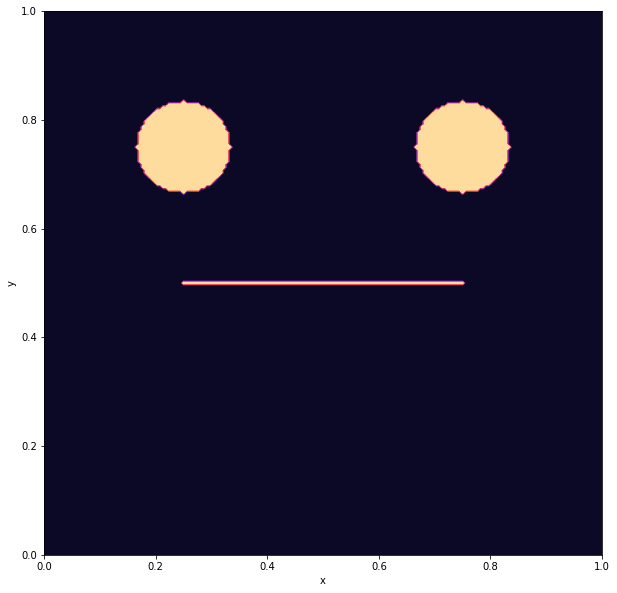

In [4]:
A = BRYAN(192)

x = np.linspace(0,1,193)
y = np.linspace(0,1,193)

fig = plt.figure(figsize = [10,10])
    
ax = fig.add_subplot(111)
X,Y = np.meshgrid(x,y)
ax.contourf(X,Y,A, cmap = 'magma')
plt.xlabel("x")
plt.ylabel("y")

plt.show()

Maintenant nous allons créer le domaine représentant la bouche après déformation de la même manière que précédemment en mettant des 1 au niveau de la bouche déformée et des 0 partout ailleurs.

In [5]:
def dom_def(N):

    ########### PENSER A METTRE UN MULTIPLE DE 12 COMME VALEUR DE N ############

    taille = (N+1)*(N+1)

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    y_haut = int(N/3)
    y_bas = int(N/4)
    borne_gauche = int(N/4)
    borne_gaubouche = int(N/3)
    borne_droibouche = int(2*N/3)
    borne_droite = int(3*N/4)
    
    MAT = np.zeros((N+1,N+1))
    
    #Construction Bouche pour déformation
    
    for i in range(y_bas,y_haut) :
        for j in range (borne_droibouche, borne_droite + 1):
            if i == (N - j) :
                MAT[i][j] = 1.

    for i in range (borne_gaubouche, borne_droibouche + 1):
        MAT[y_haut][i] = 1.


    for i in range (y_bas,y_haut):
        MAT[i][i] = 1.

    
    return MAT

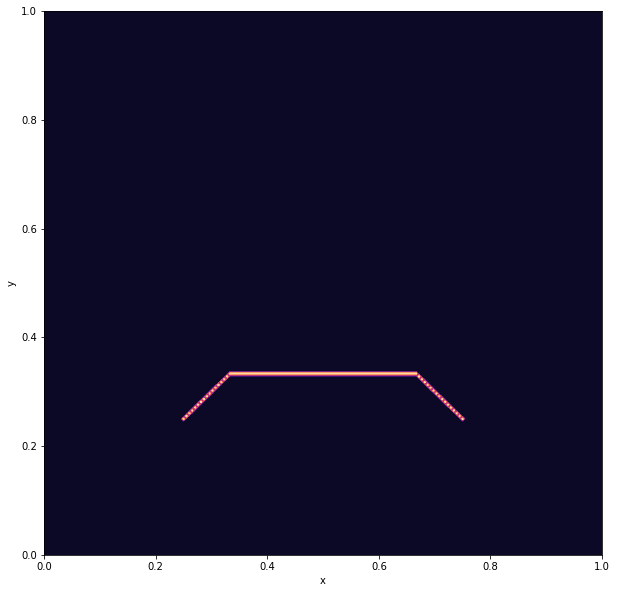

In [6]:
B = dom_def(192)

x = np.linspace(0,1,193)
y = np.linspace(0,1,193)

fig = plt.figure(figsize = [10,10])
    
ax = fig.add_subplot(111)
X,Y = np.meshgrid(x,y)
ax.contourf(X,Y,B, cmap = 'magma')
plt.xlabel("x")
plt.ylabel("y")

plt.show()

Finalement, nous allons reproduire seulement la bouche de Bryan (nous verrons l'intérêt de cette démarche par la suite).

In [7]:
def dom_init(N):

    ########### PENSER A METTRE UN MULTIPLE DE 12 COMME VALEUR DE N ############
    
    taille = (N+1)*(N+1)

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)
    
    MAT = np.zeros((N+1,N+1))
    
    #Construction Bouche

    for i in np.arange(int(N/4),int(3*N/4) +1):
        MAT[int(2*N/3)][i] = 1.
        
    return MAT

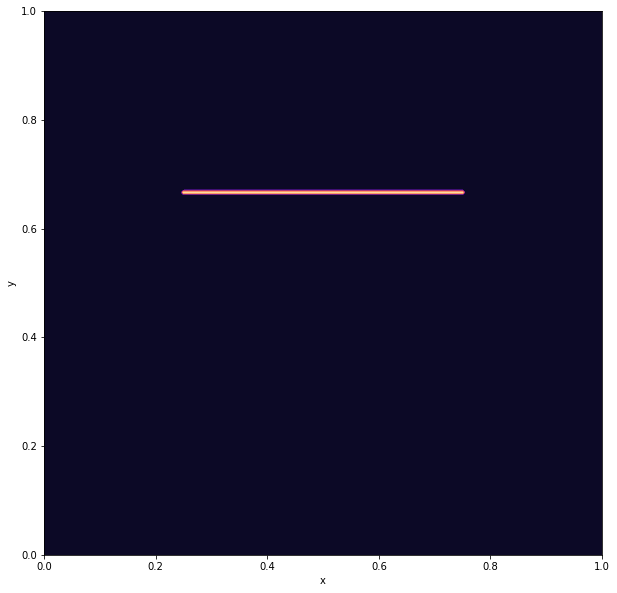

In [8]:
C = dom_init(192)

x = np.linspace(0,1,193)
y = np.linspace(0,1,193)

fig = plt.figure(figsize = [10,10])
    
ax = fig.add_subplot(111)
X,Y = np.meshgrid(x,y)
ax.contourf(X,Y,C, cmap = 'magma')
plt.xlabel("x")
plt.ylabel("y")

plt.show()

Maintenant nous allons ajouter les codes pour l'élasticité linéaire, comme fait dans les rapports précédent, nous ne détaillerons donc pas ces codes.

In [9]:
def Laplacien(N):
    """Retourne une matrice sparse de taille (N+1)*(N+1) correspondant 
    à la discrétisation du Laplacien sur l'intégralité du maillage"""
    
    h = 1./N
    h2 = h*h
    taille = (N+1)*(N+1)

    diags = np.zeros((5,taille))

    #Diagonale principale
    diags[2,:] = 1.
    diags[2, N+2:taille - (N+2)] = -4./h2
    diags[2, np.arange(2*N+1, taille, N+1)] = 1.
    diags[2, np.arange(2*N+2, taille, N+1)] = 1.
              
    #Diagonale "-1"
    diags[1,N+1:taille-(N+1)] = 1./h2
    diags[1, np.arange(2*N, taille, N+1)] = 0.
    diags[1, np.arange(2*N+1, taille, N+1)] = 0.
    
    #Diagonale "+1"
    diags[3, N+3:taille-(N+1)] = 1./h2
    diags[3, np.arange(2*N+2, taille, N+1)] = 0.
    diags[3, np.arange(2*N+3, taille, N+1)] = 0.

    #Diagonale "-(N+1)"
    diags[0, 1 : taille - (2*N+3)] = 1./h2
    diags[0, np.arange(N,taille,N+1)] = 0.
    diags[0, np.arange(N+1,taille,N+1)] = 0.

    #Diagonale "+(N+1)"
    diags[4, taille - N*N + 2 : taille - 1] = 1./h2
    diags[4, np.arange(taille - N*N + 1 + N ,taille,N+1)] = 0.
    diags[4, np.arange(taille - N*N + 2 + N ,taille,N+1)] = 0.

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-(N+1),-1,0,1,(N+1)],taille,taille, format = "csr")
    
    return A


In [10]:
def matrix_croi(N):
    """Retourne une matrice sparse de taille (N+1)*(N+1) correspondant 
    à la discrétisation des dérivées croisées sur l'intégralité du maillage"""

    h = 1./N
    h2 = h*h
    taille = (N+1)*(N+1)

    diags = np.zeros((4,taille))

    #Diagonale "-N-2"
    diags[0, 0 : taille - 2*(N+1)] = 1./(4*h2)
    diags[0, np.arange(N-1,taille,N+1)] = 0
    diags[0, np.arange(N,taille,N+1)] = 0

    #Diagonale "-N"
    diags[1, 2 : taille - (2*N+2)] = -1./(4*h2)
    diags[1, np.arange(N+1,taille,N+1)] = 0
    diags[1, np.arange(N+2,taille,N+1)] = 0

    #Diagonale "N"
    diags[2, 2*(N+1) : taille - 2] = -1./(4*h2)
    diags[2, np.arange(2*(N+1)+(N-1),taille,N+1)] = 0
    diags[2, np.arange(2*(N+1)+N,taille,N+1)] = 0

    #Diagonale "N+2"
    diags[3, 2*(N+2) : taille] = 1./(4*h2)
    diags[3, np.arange(2*(N+2)+N-1,taille,N+1)] = 0
    diags[3, np.arange(2*(N+2)+N,taille,N+1)] = 0

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-(N+2),-N,N,(N+2)],taille,taille, format = "csr")

    return A

In [11]:
def der_sec1(N):
    """Retourne une matrice sparse de taille (N+1)*(N+1) 
    correspondant à la discrétisation de la dérivée seconde 
    par rapport à la premiere variable  sur l'intégralité du maillage"""
    
    h = 1./N
    h2 = h*h
    taille = (N+1)*(N+1)

    diags = np.zeros((3,taille))

    #Diagonale principale
    diags[1,:] = 0
    diags[1, N+2:taille - (N+2)] = -2./h2
    diags[1, np.arange(2*N+1, taille, N+1)] = 0
    diags[1, np.arange(2*N+2, taille, N+1)] = 0
              
    #Diagonale "-1"
    diags[0,N+1:taille-(N+1)] = 1./h2
    diags[0, np.arange(2*N, taille, N+1)] = 0.
    diags[0, np.arange(2*N+1, taille, N+1)] = 0.
    
    #Diagonale "+1"
    diags[2, N+3:taille-(N+1)] = 1./h2
    diags[2, np.arange(2*N+2, taille, N+1)] = 0.
    diags[2, np.arange(2*N+3, taille, N+1)] = 0.

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-1,0,1],taille,taille, format = "csr")

    return A

In [12]:
def der_sec2(N):
    """Retourne une matrice sparse de taille (N+1)*(N+1) 
    correspondant à la discrétisation de la dérivée seconde 
    par rapport à la seconde variable  sur l'intégralité du maillage"""
    
    h = 1./N
    h2 = h*h
    taille = (N+1)*(N+1)

    diags = np.zeros((3,taille))

    #Diagonale principale
    diags[1,:] = 0.
    diags[1, N+2:taille - (N+2)] = -2./h2
    diags[1, np.arange(2*N+1, taille, N+1)] = 0.
    diags[1, np.arange(2*N+2, taille, N+1)] = 0.

    #Diagonale "-(N+1)"
    diags[0, 1 : taille - (2*N+3)] = 1./h2
    diags[0, np.arange(N,taille,N+1)] = 0.
    diags[0, np.arange(N+1,taille,N+1)] = 0.

    #Diagonale "+(N+1)"
    diags[2, taille - N*N + 2 : taille - 1] = 1./h2
    diags[2, np.arange(taille - N*N + 1 + N ,taille,N+1)] = 0.
    diags[2, np.arange(taille - N*N + 2 + N ,taille,N+1)] = 0.

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-(N+1),0,(N+1)],taille,taille, format = "csr")

    return A

In [13]:
def matrix_elas(N,mu,lamb):
    """Retourne la matrice sparse globale pour la discrétisation du problème d'élasticité linéaire. 
    Cette matrice sera de taille (2*(N+1))^2. Cette fonction prend en paramètre N 
    le nbr d'intervalle de discrétisation, mu et lamb des scalaires pour l'élasticité linéaire."""

    delta = (lamb + mu)/mu

    LAP = Laplacien(N)
    CR = matrix_croi(N)
    DER1 = der_sec1(N)
    DER2 = der_sec2(N)

    #Utilisation de la fonction bmat qui permet la construction d'une matrice "par blocs".
    
    MATRIX = bmat([ [LAP + delta*DER1 , CR],[-CR , LAP + delta*DER2]], format = 'csr')

    return MATRIX

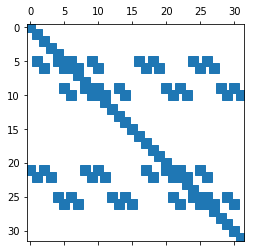

In [14]:
plt.spy(matrix_elas(3,1,0))

La matrice d'élasticié est donc bien implémentée. Maintenant, la stratégie pour résoudre notre problème sera la suivante: Nous allons écrire la fonction distance sur la bouche déformée. Nous obtiendrons une matrice où chaque élément représentera la distance par rapport à la bouche. En faisant la multiplication ponctuelle avec la matrice représentant la bouche de Bryan nous obtiendrons seulement la distance de ses points par rapport à la bouche déformée. Nous serons en mesure de créer une matrice de second membre pour l'élasticité linéaire où nous appliquerons les forces (matrice de distance) seulement sur les bords du domaine.

In [15]:
def matrix_lap(N,dt):
    """Utilisé pour le calcul de la distance par résolution de l'équation de la chaleur"""

    h = 1./N
    h2 = h*h

    #On note les inconnues de 0 à Nx suivant x et 0 à Ny suivant y. La taille du problème est donc (Nx+1)*(Ny+1).

    #Cela correspond à x_i = i*h et y_j = j*h et la numérotation (i,j) --> k := (N+1)*j+i.

    taille = (1+N)*(1+N)

    diags = np.zeros((5,taille))

    #Diagonale principale
    diags[2,:] = 1.
    diags[2, N+2:taille - (N+2)] = 1 + ((4*dt)/h2)
    diags[2, np.arange(2*N+1, taille, N+1)] = 1.
    diags[2, np.arange(2*N+2, taille, N+1)] = 1.
              
    #Diagonale "-1"
    diags[1,N+1:taille-(N+1)] = -dt/h2
    diags[1, np.arange(2*N, taille, N+1)] = 0.
    diags[1, np.arange(2*N+1, taille, N+1)] = 0.
    
    #Diagonale "+1"
    diags[3, N+3:taille-(N+1)] = -dt/h2
    diags[3, np.arange(2*N+2, taille, N+1)] = 0.
    diags[3, np.arange(2*N+3, taille, N+1)] = 0.

    #Diagonale "-(N+1)"
    diags[0, 1 : taille - (2*N+3)] = -dt/h2
    diags[0, np.arange(N,taille,N+1)] = 0.
    diags[0, np.arange(N+1,taille,N+1)] = 0.

    #Diagonale "+(N+1)"
    diags[4, taille - N*N + 2 : taille - 1] = -dt/h2
    diags[4, np.arange(taille - N*N + 1 + N ,taille,N+1)] = 0.
    diags[4, np.arange(taille - N*N + 2 + N ,taille,N+1)] = 0.

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-(N+1),-1,0,1,(N+1)],taille,taille, format = "csr")

    return A

def chaleurdist(MAT,N,dt,t):

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    taille = (N+1)*(N+1)

    T = np.zeros(taille)          #Initialisation de la solution finale
    
    for i in range(N+1):
        for j in range(N+1):
            k = i*(N+1) + j
            T[k] = MAT[i][j]

    for i in range(t):
        T = sci.spsolve(matrix_lap(N,dt), T)
         
    return T

def dist(MAT,N,dt):

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    T = chaleurdist(MAT,N,dt,1)

    dist  = -np.log(T)*np.sqrt(dt)
    dist[~np.isfinite(dist)] = 0 


    return dist.reshape((N+1,N+1))

In [16]:
def second_membre(N,mu,lamb):

    taille = (N+1)*(N+1)

    DEF = dom_def(N)
    INIT = dom_init(N)
    
    DIST = dist(dom_def(N),N,0.00001)

    F = DIST*INIT

    M = np.min(F[int(2*N/3),int(N/4):int(3*N/4)])
    
    F[0,:] = F[int(2*N/3),:]
    F[N,:] = F[int(2*N/3),:]
    
    for i in range(0,int(N/4)):
        F[0,i] = M
        F[N,i] = M
        F[0,N-i] = M
        F[N,N-i] = M 

    F[int(2*N/3),:] = np.zeros(N+1)
    
    S = np.zeros(2*taille)

    S[taille:2*taille] = np.ravel(F)/mu
    
    return [DIST,F,S]

C:\Users\Jari\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log


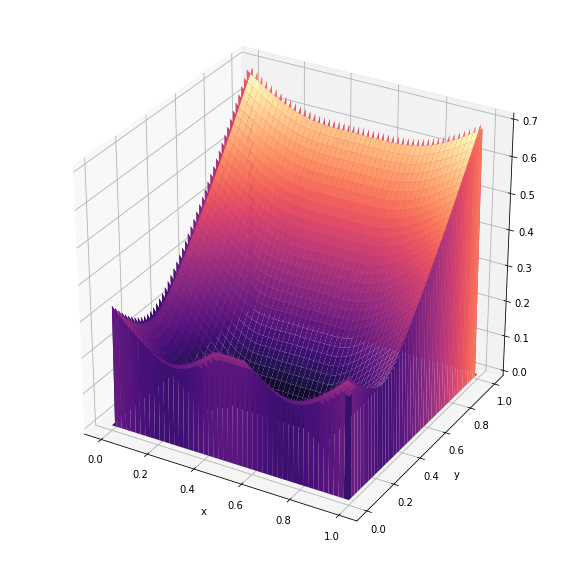

In [17]:
[DIST,F,S] = second_membre(192,1,0)

x = np.linspace(0,1,193)
y = np.linspace(0,1,193)

fig = plt.figure(figsize = [10,10])
    
ax = fig.add_subplot(111,projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,DIST.reshape(193,193), cmap = 'magma')

plt.xlabel("x")
plt.ylabel("y")

plt.show()

Nous avons donc ici la matrice du produit ponctuel entre la matrice distance par rapport à la bouche déformée de Bryan et la matrice représentant la bouche initiale.
  
Ensuite nous allons résoudre notre problème d'élasticité linéaire exactement comme dans le code précédent avec cette matrice de distance par rapport à la bouche déformée utilisée en tant que second membre.

In [18]:
def resolution(N,mu,lamb):
    
    #Pour une valeur de delta égale = 1 il suffit de prendre lambda = 0
    
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    taille = (N+1)*(N+1)

    delta = (lamb + mu)/mu

    MAT = matrix_elas(N,mu,lamb)

    [DIST,F,S] = second_membre(N,mu,lamb)
    
    U = sci.spsolve(MAT,S)

    U1 = U[0:taille]
    U2 = U[taille : 2*taille]
    
    return [U1,U2]

In [19]:
def graphe_reso(N,mu,lamb):
    
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)
    
    taille = (N+1)*(N+1)
    
    [U1,U2] = resolution(N,mu,lamb)
        
    fig = plt.figure(figsize = [16,12])
    
    ax = fig.add_subplot(2,2,1,projection='3d')
    X,Y = np.meshgrid(x,y)
    ax.plot_surface(X,Y, U1.reshape(N+1,N+1), cmap='plasma')
    plt.title("Solution discrétisée U1")
    plt.xlabel("x")
    plt.ylabel("y")

    ax = fig.add_subplot(2,2,2,projection='3d')
    X,Y = np.meshgrid(x,y)
    ax.plot_surface(X,Y, U2.reshape(N+1,N+1), cmap='plasma')
    plt.title("Solution de U2")
    plt.xlabel("x")
    plt.ylabel("y")


    plt.show()

C:\Users\Jari\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log


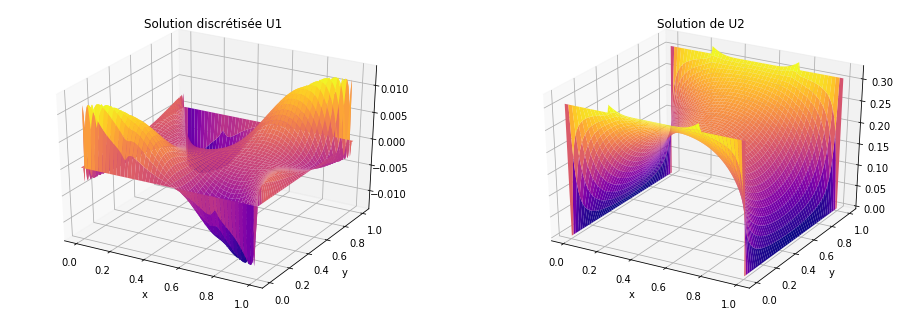

In [20]:
graphe_reso(192,1,0)

Nous allons enfin afficher notre Bryan initial, ensuite nous allons afficher Bryan après deux déformations différentes: la première nous affiche un Bryan triste d'apprendre qu'il n'aura pas de séance groupe de travail thématique cette semaine, puis un Bryan très heureux en sortant d'un cours de GTT.

In [21]:
def deformation(N,mu,lamb):

    taille = (N+1)*(N+1)

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    
    [U1,U2] = resolution(N,mu,lamb)

    U1 = U1.reshape(N+1,N+1)
    U2 = U2.reshape(N+1,N+1)

    Bryan = BRYAN(N)

    X,Y = np.meshgrid(x,y)
    
    fig2 = plt.figure(figsize = [10,10])
    
    ax = fig2.add_subplot(111)
    ax.contourf(X,Y,Bryan)
    plt.title("Bryan avant GTT")
    plt.xlabel("x")
    plt.ylabel("y")
    
    fig1 = plt.figure(figsize = [10,10])
    
    ax = fig1.add_subplot(111)

    X1 =  X + U1
    Y1 =  Y + U2
    
    ax.contourf(X1,Y1,Bryan)
    plt.title("Bryan quand y a pas GTT")
    plt.xlabel("x")
    plt.ylabel("y")


    fig3 = plt.figure(figsize = [10,10])
    ax = fig3.add_subplot(111)

    X2 =  X - U1
    Y2 =  Y - U2
    
    ax.contourf(X2,Y2,Bryan)
    plt.title("Bryan après GTT")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.show()

C:\Users\Jari\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log


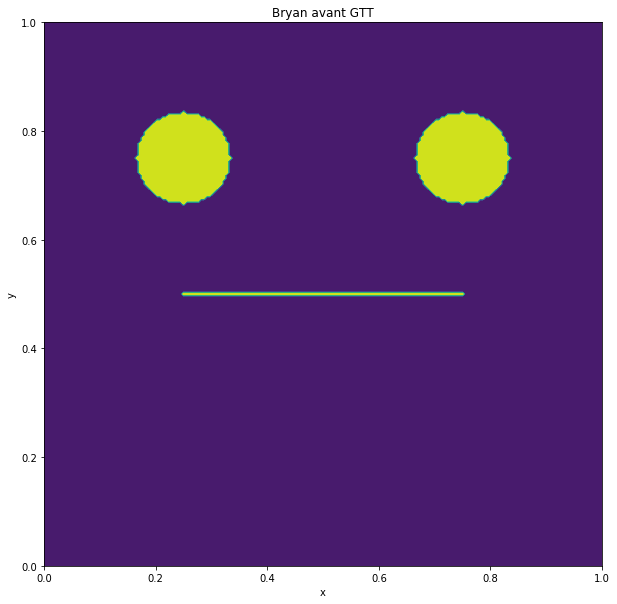

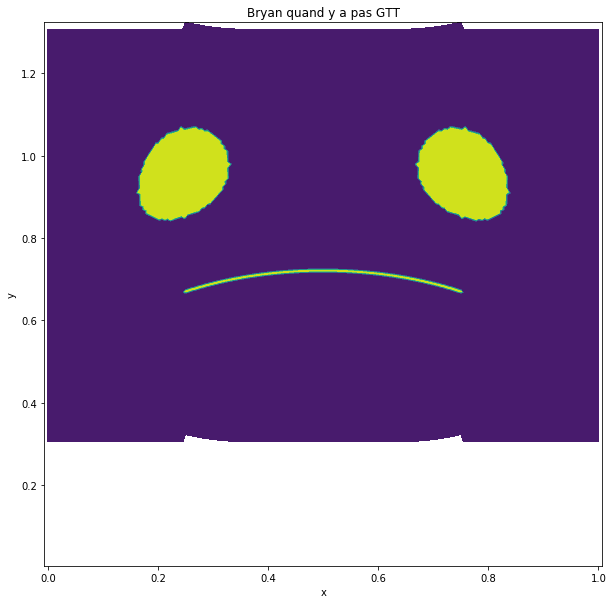

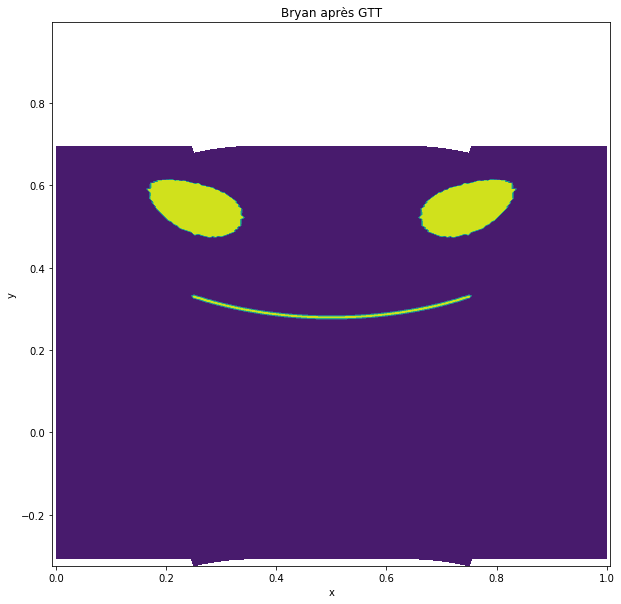

In [22]:
deformation(192,1,0)